# DBSCAN

In [36]:
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors, KDTree
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from lib.pca import PCAFeatures
import lib.bovw as bovw
from lib.alexnet import AlexNetFeatures
import lib.utils as utils

## 1. PCA Features

In [2]:
train_imgs, train_labels = utils.load_train_images()
print(len(train_imgs))

3500


In [3]:
train_resized_imgs = utils.resize_imgs(train_imgs)
mean_img = utils.get_mean_img(train_resized_imgs)
train_norm_imgs = utils.basic_imgs_normalization(train_resized_imgs)
train_features = utils.image_liniarization(train_norm_imgs)
train_features.shape

(3500, 7500)

In [4]:
pca_300 = PCAFeatures(dim=300)
pca_300.fit(train_features)
train_features_reduced_300 = pca_300.transform(train_features)
print(train_features_reduced_300.shape)

(3500, 300)


In [5]:
def compute_distance_matrix(train_features, metric="euclidean"):
    return metrics.pairwise_distances(train_features, metric=metric, n_jobs=-1)

In [6]:
train_distance_matrix = compute_distance_matrix(train_features_reduced_300)
train_distance_matrix.shape

(3500, 3500)

In [7]:
def eps_search(train_distance_matrix, metric="precomputed", k=1):
    nn = NearestNeighbors(n_neighbors=k + 1, metric=metric)
    nn.fit(train_distance_matrix)
    dist = nn.kneighbors(train_distance_matrix)[0][:, k]
    dist = np.sort(dist)
    return dist

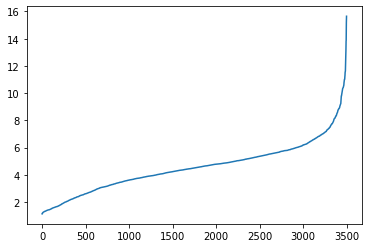

9.177299666208441


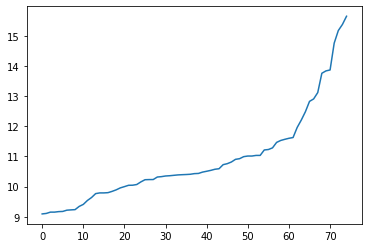

In [19]:
dists = eps_search(train_distance_matrix, k=4)
plt.plot(dists)
plt.show()
plt.plot(dists[3425:3500])
print(dists[3430])

In [20]:
def try_min_samples(eps, min_sample_options):
    for min_samples in min_sample_options:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed", n_jobs=-1)
        dbscan.fit(train_distance_matrix)
        labels_set = set(dbscan.labels_.tolist())
        num_clusters = len(labels_set) - (-1 in labels_set)
        print(f"For min_samples={min_samples}: {num_clusters} clusters")

In [21]:
min_sample_options = list(range(90, 100))
try_min_samples(8.5, min_sample_options)

For min_samples=90: 11 clusters
For min_samples=91: 11 clusters
For min_samples=92: 11 clusters
For min_samples=93: 11 clusters
For min_samples=94: 10 clusters
For min_samples=95: 10 clusters
For min_samples=96: 10 clusters
For min_samples=97: 10 clusters
For min_samples=98: 10 clusters
For min_samples=99: 9 clusters


In [22]:
def print_cluster_sizes(dbscan):
    cnt = Counter(dbscan.labels_.tolist())
    for label in cnt:
        if label == -1:
            continue
        print(f"Cluster {label}: {cnt[label]}")
    print(f"Outliers: {cnt[-1]}")

In [25]:
dbscan = DBSCAN(eps=9, min_samples=4, metric="precomputed", n_jobs=-1)
dbscan.fit(train_distance_matrix)
print_cluster_sizes(dbscan)

Cluster 0: 207
Cluster 1: 20
Cluster 2: 655
Cluster 3: 350
Cluster 4: 241
Cluster 5: 18
Cluster 6: 8
Cluster 7: 114
Cluster 8: 341
Cluster 9: 123
Cluster 10: 109
Cluster 11: 93
Cluster 12: 272
Cluster 13: 274
Cluster 14: 33
Cluster 15: 21
Cluster 16: 104
Cluster 17: 325
Cluster 18: 34
Cluster 19: 16
Cluster 20: 8
Cluster 27: 11
Cluster 21: 21
Cluster 22: 15
Cluster 23: 9
Cluster 28: 5
Cluster 24: 15
Cluster 25: 9
Cluster 26: 7
Cluster 29: 4
Outliers: 38


In [33]:
def dbscan_clustering(eps, min_samples, train_features, train_distance_matrix, train_labels, n_true_clusters):
    """DBSCAN clustering using given features, returns a fitted estimator and a many-to-one
    mapping from the clusters to the training labels based on the most frequent label
    in a cluster.
    """
    # Fit the estimator and predict the labels
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric="precomputed", n_jobs=-1)
    dbscan.fit(train_distance_matrix)
    predicted_labels = dbscan.labels_

    # compute silhouette scores for every sample
    sil_avg = metrics.silhouette_score(train_features, predicted_labels)
    sample_sil_values = metrics.silhouette_samples(train_features, predicted_labels)

    labels_set = set(dbscan.labels_.tolist())
    n_clusters = len(labels_set) - (-1 in labels_set)
    
    # the silhouette plot for each cluster
    fig, ax = plt.subplots()
    ax.set_xlim([-0.1, 1])
    skip_between = 10
    ax.set_ylim([0, np.count_nonzero(predicted_labels != -1) + (n_clusters + 1) * skip_between])

    y_min = 10
    for i in range(n_clusters):
        sil_values = sample_sil_values[predicted_labels == i]
        sil_values.sort()

        size = sil_values.shape[0]
        y_max = y_min + size

        color = cm.nipy_spectral((i + 1) / n_clusters)
        ax.fill_betweenx(
            np.arange(y_min, y_max),
            0,
            sil_values,
            facecolor=color,
            edgecolor=color,
        )

        ax.text(-0.1, y_min + 0.5 * size, str(i))
        y_min = y_max + skip_between

    ax.set_title(f"Silhouette plot for {n_clusters} clusters")
    ax.set_xlabel("Silhouette scores")
    ax.set_ylabel("Cluster")

    # plot the silhouette mean score
    ax.axvline(x=sil_avg, color="red")

    ax.set_yticks([])
    ax.set_xticks(np.arange(6) / 5)

    plt.show()

    # plot for DBSCAN clustering vs. actual distribution
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)

    # use PCA for 2D plot
    pca_2 = PCAFeatures(2)
    pca_2.fit(train_features)
    train_features_2 = pca_2.transform(train_features)

    colors = cm.nipy_spectral((predicted_labels.astype(float) + 1) / n_clusters)
    ax1.scatter(
        train_features_2[:, 0], train_features_2[:, 1],
        marker='.', s=20, c=colors
    )
    ax1.set_title("Clustered data")
    ax1.axes.xaxis.set_visible(False)
    ax1.axes.yaxis.set_visible(False)

    colors = cm.nipy_spectral(
        (np.array(train_labels).astype(float) + 1) / n_true_clusters
    )
    ax2.scatter(
        train_features_2[:, 0], train_features_2[:, 1],
        marker='.', s=20, c=colors
    )
    ax2.set_title("Actual distribution of the data")
    ax2.axes.xaxis.set_visible(False)
    ax2.axes.yaxis.set_visible(False)

    # compute for each cluster the most frequent training label in that cluster
    cnt_clusters = defaultdict(Counter)
    for true_label, cluster_label in zip(train_labels, predicted_labels):
        cnt_clusters[cluster_label][true_label] += 1
    cluster_to_label = {}
    for cluster in cnt_clusters:
        cluster_to_label[cluster] = cnt_clusters[cluster].most_common(1)[0][0]
    cluster_to_label[-1] = -1

    # remap cluster labels based on the many-to-one relation and plot the generated classes
    remapped_labels = np.array([cluster_to_label[cluster] for cluster in predicted_labels])
    colors = cm.nipy_spectral((remapped_labels.astype(float) + 1) / n_true_clusters)
    ax3.scatter(
        train_features_2[:, 0], train_features_2[:, 1],
        marker='.', s=20, c=colors
    )
    ax3.set_title("Merged clusters using training labels")
    ax3.axes.xaxis.set_visible(False)
    ax3.axes.yaxis.set_visible(False)


    plt.show()

    return dbscan, cluster_to_label

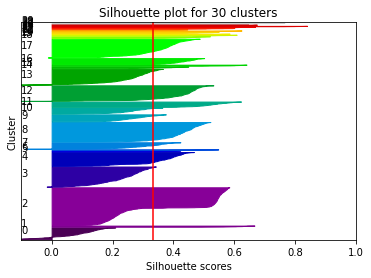

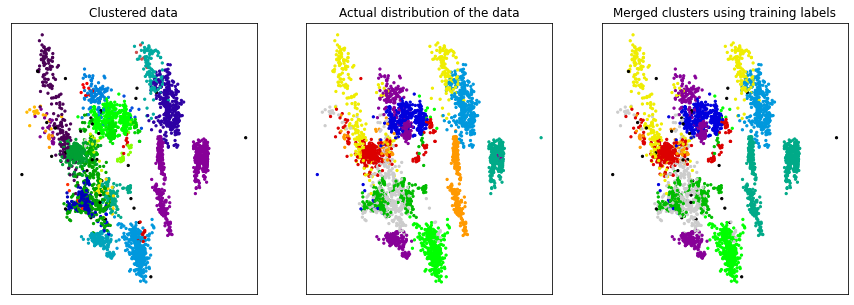

In [35]:
dbscan, cluster_to_label = dbscan_clustering(
    eps=9,
    min_samples=4,
    train_features=train_features_reduced_300,
    train_distance_matrix=train_distance_matrix,
    train_labels=train_labels,
    n_true_clusters=10,
)

In [37]:
predicted_labels = dbscan.labels_
predicted_labels_for_acc = np.array(
    [cluster_to_label[cluster] for cluster in predicted_labels]
)
print(predicted_labels.shape)
predicted_labels_for_nmi = predicted_labels.copy()
cnt = 100
for i in range(len(predicted_labels_for_nmi)):
    if predicted_labels_for_nmi[i] == -1:
        predicted_labels_for_nmi[i] = cnt
        cnt += 1
print(f"Train ACC: {metrics.accuracy_score(train_labels, predicted_labels_for_acc)}")
print(f"Train NMI: {metrics.normalized_mutual_info_score(train_labels, predicted_labels_for_nmi)}")

(3500,)
Train ACC: 0.9017142857142857
Train NMI: 0.8561312954942878


In [38]:
def predict_label_for_test(test_features, train_features, dbscan, cluster_to_label):
    kd_tree = KDTree(train_features[dbscan.core_sample_indices_])
    predicted_test_labels_acc = []
    predicted_test_labels_nmi = []
    cnt = 100
    for i in tqdm(range(len(test_features))):
        d, idx = kd_tree.query([test_features[i, :]], k=2)
        closest_core = dbscan.core_sample_indices_[idx[0][1]]
        dist_to_core = d[0][1]
        if dist_to_core <= dbscan.get_params()["eps"]:
            cluster = dbscan.labels_[closest_core]
            assert cluster != -1
            predicted_test_labels_acc.append(
                cluster_to_label[cluster]
            )
            predicted_test_labels_nmi.append(cluster)
        else:
            predicted_test_labels_acc.append(-1)
            predicted_test_labels_nmi.append(cnt)
            cnt += 1
    return (
        np.array(predicted_test_labels_acc),
        np.array(predicted_test_labels_nmi),
    )

In [39]:
test_imgs, test_labels = utils.load_test_images()
print(len(test_imgs))
test_resized_imgs = utils.resize_imgs(test_imgs)
test_norm_imgs = utils.basic_imgs_normalization(test_resized_imgs, mean_img=mean_img)
test_features = utils.image_liniarization(test_norm_imgs)
print(test_features.shape)
test_features_reduced_300 = pca_300.transform(test_features)
print(test_features_reduced_300.shape)

1500
(1500, 7500)
(1500, 300)


In [40]:
test_predicted_labels_acc,  test_predicted_labels_nmi = predict_label_for_test(
    test_features_reduced_300,
    train_features_reduced_300,
    dbscan,
    cluster_to_label
)
print("\n", test_predicted_labels_acc.shape)
print(test_predicted_labels_nmi.shape)
print(f"Train ACC: {metrics.accuracy_score(test_labels, test_predicted_labels_acc)}")
print(f"Train NMI: {metrics.normalized_mutual_info_score(test_labels, test_predicted_labels_nmi)}")

100%|██████████| 1500/1500 [00:00<00:00, 4843.65it/s]
 (1500,)
(1500,)
Train ACC: 0.8986666666666666
Train NMI: 0.8542006443146063

